# Deep Learning Project 3
## Spring 2025

## Jailbreaking Deep Models Project

This project will comprise 25% of your overall grade. Please perform this project in groups of (at most) 3. If you are looking for project team members, please broadcast your interest in the Class Slack in the *find-a-teammate* channel.

## Jailbreaking Deep Models

Much of the class has focused on training deep neural networks that perform well on certain tasks. In this final project, you are tasked with launching effective adversarial attacks on production-grade, publicly posted models, and degrade their performance. We will focus on image classifiers. Recall that we had discussed in class that deep classifiers are surprisingly brittle; an attacker can design carefully crafted perturbations that misclassify a test data point, and therefore reduce model performance to very low rates (even all the way down to 0%).

![Adversarial Attack Example](example.png)

                                            Figure 1: Example of an adversarial attack.

The main challenge is to design attacks that are subtle or imperceptible. That is, the perturbed test image should resemble the original test image as much as possible. Mathematically, we require that the distance (measured in some sense) between the original and test images is small. Typical measures of distance in such cases are the **L∞ distance** (which upper-bounds how much each image pixel is allowed to be perturbed; these are called **L∞** or **pixel-wise attacks**), and the **L0 distance** (which upper-bounds how many pixels are allowed to be perturbed; these are called **L0** or **patch attacks**).

In [10]:
import json, pathlib, torch, itertools,torchvision, platform, sys, numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm.auto import tqdm
import pathlib, json
from pathlib import Path
from torchvision.datasets.utils import download_url
import urllib.request, json, pathlib, torch, torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)"""

print(torch.__version__, platform.platform(), sys.version.split()[0])

def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print("Using:", device)

2.5.1 macOS-15.4.1-arm64-arm-64bit 3.12.4
Using: mps


In [2]:
"""import zipfile, pathlib, shutil, os

zip_path   = pathlib.Path("TestDataSet.zip")   # adjust if the name/location differs
extract_to = pathlib.Path("TestDataSet")       # final folder expected by ImageFolder

# ---- remove partially‑extracted folders if you re‑run ---
if extract_to.exists() and any(extract_to.iterdir()):
    print("Cleaning old extraction …")
    shutil.rmtree(extract_to)

print(f"Extracting {zip_path} → {extract_to}/")
with zipfile.ZipFile(zip_path) as zf:
    zf.extractall(path=extract_to)

print("✅ Done.  Top‑level contents:")
for p in list(extract_to.iterdir())[:5]:
    print("   ", p.name, "(dir)" if p.is_dir() else "")"""

'import zipfile, pathlib, shutil, os\n\nzip_path   = pathlib.Path("TestDataSet.zip")   # adjust if the name/location differs\nextract_to = pathlib.Path("TestDataSet")       # final folder expected by ImageFolder\n\n# ---- remove partially‑extracted folders if you re‑run ---\nif extract_to.exists() and any(extract_to.iterdir()):\n    print("Cleaning old extraction …")\n    shutil.rmtree(extract_to)\n\nprint(f"Extracting {zip_path} → {extract_to}/")\nwith zipfile.ZipFile(zip_path) as zf:\n    zf.extractall(path=extract_to)\n\nprint("✅ Done.  Top‑level contents:")\nfor p in list(extract_to.iterdir())[:5]:\n    print("   ", p.name, "(dir)" if p.is_dir() else "")'

In [3]:
rm -rf "__MACOSX"

In [6]:
root = Path("TestDataSet")        

subdirs = sorted([p.name for p in root.iterdir() if p.is_dir()])
print(f"{len(subdirs)} class folders found:")
print(subdirs[:10], "...")        

2 class folders found:
['TestDataSet', '__MACOSX'] ...


In [7]:
root = Path("TestDataSet/TestDataSet")        

# 1) Number of class folders
class_folders = [p for p in root.iterdir() if p.is_dir()]
print("Folders:", len(class_folders))         

# 2) First 5 folders and image counts
for p in sorted(class_folders)[:5]:
    n_imgs = len(list(p.glob("*.*")))
    print(f"{p.name:10s}  →  {n_imgs:3d} images")

# 3) Total number of images
total_imgs = sum(len(list(p.glob("*.*"))) for p in class_folders)
print("Total images:", total_imgs)

Folders: 100
n02672831   →    6 images
n02676566   →    5 images
n02687172   →    5 images
n02690373   →    5 images
n02692877   →    5 images
Total images: 501


In [12]:
for p in itertools.islice(pathlib.Path(".").rglob("*.json"), 20):
    print(p)

imagenet_class_index.json
Jailbreaking-Deep-Models/imagenet_class_index.json
Jailbreaking-Deep-Models/TestDataSet/TestDataSet/labels_list.json
TestDataSet/TestDataSet/labels_list.json


In [13]:
root         = Path("TestDataSet/TestDataSet")          
mapping_path = root / "labels_list.json"                
print(root.is_dir(), mapping_path.is_file())

True True


In [14]:
with open(mapping_path) as f:
    data = json.load(f)

# peek at 3 entries
print(type(data))
print(list(itertools.islice(data, 3)))

<class 'list'>
['401: accordion', '402: acoustic guitar', '403: aircraft carrier']


In [15]:
pairs = [s.split(": ", 1) for s in data]            # ['401', 'accordion']
class2idx = {name.strip(): int(idx) for idx, name in pairs}
print("Parsed", len(class2idx), "entries.")

Parsed 100 entries.


In [16]:
root = Path("TestDataSet/TestDataSet")   
ds = datasets.ImageFolder(root=str(root), transform=transforms.ToTensor())

print("First 10 folders ImageFolder sees:", ds.classes[:10])
missing = [c for c in ds.classes if c not in class2idx]
print("Folders without a JSON entry:", missing)

First 10 folders ImageFolder sees: ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877', 'n02699494', 'n02701002', 'n02704792', 'n02708093', 'n02727426']
Folders without a JSON entry: ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877', 'n02699494', 'n02701002', 'n02704792', 'n02708093', 'n02727426', 'n02730930', 'n02747177', 'n02749479', 'n02769748', 'n02776631', 'n02777292', 'n02782093', 'n02783161', 'n02786058', 'n02787622', 'n02788148', 'n02790996', 'n02791124', 'n02791270', 'n02793495', 'n02794156', 'n02795169', 'n02797295', 'n02799071', 'n02802426', 'n02804414', 'n02804610', 'n02807133', 'n02808304', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02817516', 'n02823428', 'n02823750', 'n02825657', 'n02834397', 'n02835271', 'n02837789', 'n02840245', 'n02841315', 'n02843684', 'n02859443', 'n02860847', 'n02865351', 'n02869837', 'n02870880', 'n02871525', 'n02877765', 'n02879718', 'n02883205', 'n02892201', 'n02892767', 'n02894605', 'n02895154', 'n02906734

# Tasks

For your project, implement the following tasks:

# Task 1: Basics

The goal is to attack a **ResNet-34** model that is trained to classify the **ImageNet-1K** dataset. 

ImageNet-1K is a well-known dataset in computer vision research, containing visually challenging images from **1000 classes**. Networks trained on ImageNet typically perform well on other tasks too.

---

## Step 1: Load the Pretrained ResNet-34 Model

You can download the ResNet-34 model from TorchVision using the following command:

```python
import torchvision

pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Download the attached test dataset. This is a subset of images taken from 100 classes of the ImageNet-1K dataset. The included `.json` file has the associated label names and ImageNet label indices.

We will need to preprocess the images like this before doing anything else:

`mean_norms = np.array([0.485, 0.456, 0.406])`  
`std_norms = np.array([0.229, 0.224, 0.225])`  
`plain_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean_norms, std=std_norms)`])`  

`dataset_path = "./TestDataSet"`  
`dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)`

Evaluate the pre-trained ResNet-34 model on this test dataset; note that to validate a prediction you will have to look at the predicted class label and match it to the corresponding index in the `.json` file.

Report top-1 and top-5 accuracy for this dataset. *(Top-k accuracy is calculated as follows:* 
*Compute the k most likely class labels according to the classifier, and return True if any of these k labels matches the ground truth.)*

In [17]:
# 1) Downloading the full index
download_url(
    "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json",
    ".",                      # save to current directory
    "imagenet_class_index.json"
)
print("Downloaded imagenet_class_index.json:", pathlib.Path("imagenet_class_index.json").exists())

# 2) Loading it
with open("imagenet_class_index.json") as f:
    full_map = json.load(f)

# Quick sanity:
print("Entry 0:", full_map["0"])
print("Entry 401:", full_map["401"])

Using downloaded and verified file: ./imagenet_class_index.json
Downloaded imagenet_class_index.json: True
Entry 0: ['n01440764', 'tench']
Entry 401: ['n02672831', 'accordion']


In [18]:
syn2idx = {v[0]: int(k) for k, v in full_map.items()}   # synset → integer

In [19]:
# STEP 2: creating a subset mapping for our 100 folders
root = pathlib.Path("TestDataSet/TestDataSet")
subset_synsets = [p.name for p in root.iterdir() if p.is_dir()]
class2idx = {syn: syn2idx[syn] for syn in subset_synsets}   # len == 100

In [20]:
# STEP 3: building the ImageFolder and remap targets 
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
ds   = datasets.ImageFolder(root=str(root), transform=tfms)

# inner idx (0‑99) ➜ true ImageNet idx (0‑999)
inner2img = {inner: class2idx[syn] for inner, syn in enumerate(ds.classes)}
ds.targets = [inner2img[t] for t in ds.targets]

In [21]:
# 1) Rewriting ds.samples with the new labels
new_samples = [(path, inner2img[inner]) for path, inner in ds.samples]
ds.samples  = new_samples

# 2) Syncing ds.targets
ds.targets = [label for _, label in ds.samples]

# Quick sanity:
print("Sample labels now:", ds.targets[:10], "(should be in 0–999 range)")

Sample labels now: [401, 401, 401, 401, 401, 401, 402, 402, 402, 402] (should be in 0–999 range)


In [23]:
# STEP 4: loader + evaluation
loader = DataLoader(ds, batch_size=64, shuffle=False,
                    num_workers=4, pin_memory=True)

model = torchvision.models.resnet34(weights="IMAGENET1K_V1")\
                 .to(device).eval()

@torch.no_grad()
def topk_correct(logits, y, k):
    return (logits.topk(k, 1).indices == y[:, None])\
             .any(1).float().sum().item()

def evaluate(dl):
    top1 = top5 = 0.0
    n = len(dl.dataset)
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        top1 += topk_correct(out, y, 1)
        top5 += topk_correct(out, y, 5)
    return top1 / n * 100, top5 / n * 100

top1, top5 = evaluate(loader)
print(f"\nCorrected Baseline → Top-1: {top1:.2f}%   Top-5: {top5:.2f}%")


Corrected Baseline → Top-1: 75.85%   Top-5: 94.01%


## Task 2: Pixel-wise attacks

A common and simple algorithm for mounting an L∞ attack is called **Fast Gradient Sign Method (FGSM)**; this implements a single step of gradient ascent (in pixel space) and truncates the values of the gradients to at most ε. Mathematically, we can write this as:

x ← x + ε * sign(∇ₓL)

where *L* is the cross-entropy loss, the gradient is with respect to the input parameters (not the weights – so remember that!), and the `sign` operation just truncates the gradient to the unit L∞ cube. *(Convince yourself that this makes sense!)*

The parameter **ε** is called the **attack budget**. If raw (unpreprocessed) images have pixel values of 0–255, an attack budget of **ε = 0.02** roughly corresponds to changing each pixel value in the raw image by at most ±1.

---

Implement FGSM for each image in the test dataset for **ε = 0.02**.

- Visualize 3 to 5 test cases where the original model no longer classifies as expected. Your visualization can be similar to the example shown above.
- You should now have a new set of 500 images; verify that the new images are visually similar to the original test set and that the L∞ distance between new and original is no greater than **ε = 0.02**.
- Save this dataset (call this **“Adversarial Test Set 1”**).
- Evaluate ResNet-34 performance and report new top-1 and top-5 accuracy scores.

You should strive to achieve an **accuracy drop of at least 50%** relative to your baseline numbers from Task 1 (so if your earlier metrics were above 80%, then your new metrics should be below 30%).

In [24]:
# 1) Setup FGSM 

# reusing mean/std from Task 1
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# per-channel normalised epsilon
eps = 0.02
eps_norm = torch.tensor([eps/s for s in std], device=device).view(1,3,1,1)

# clamp bounds in *normalized* space
min_norm = torch.tensor([(0-m)/s for m,s in zip(mean,std)], device=device).view(1,3,1,1)
max_norm = torch.tensor([(1-m)/s for m,s in zip(mean,std)], device=device).view(1,3,1,1)

# inverse-normalize transform for visualization / saving
inv_norm = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean,std)],
    std =[ 1/s  for    s  in    std  ]
)

In [25]:
# 2) Generating adversarial images 
orig_batches, adv_batches, labels_batches = [], [], []

model.eval()  
for x, y in loader:
    x, y = x.to(device), y.to(device)
    x.requires_grad_()
    
    # forward + loss
    logits = model(x)
    loss   = F.cross_entropy(logits, y)
    
    # backprop to get ∇_x L
    model.zero_grad()
    loss.backward()
    
    # FGSM step in normalized space
    x_adv = x + eps_norm * x.grad.sign()
    
    # clamp back into valid normalized range
    x_adv = torch.max(torch.min(x_adv, max_norm), min_norm).detach()
    
    # collect
    orig_batches.append(x.detach())
    adv_batches.append(x_adv)
    labels_batches.append(y)

# flatten into big tensors
orig_imgs = torch.cat(orig_batches)   
adv_imgs  = torch.cat(adv_batches)
adv_lbls  = torch.cat(labels_batches)

In [26]:
# 3) Evaluating FGSM set

# wrapping into a loader
adv_ds     = TensorDataset(adv_imgs, adv_lbls)
adv_loader = DataLoader(adv_ds, batch_size=64, shuffle=False)

# reusing our evaluate() from Task 1
top1_fgsm, top5_fgsm = evaluate(adv_loader)
print(f"FGSM (ε={eps}) → Top-1: {top1_fgsm:.2f}%   Top-5: {top5_fgsm:.2f}%")

FGSM (ε=0.02) → Top-1: 3.19%   Top-5: 20.76%


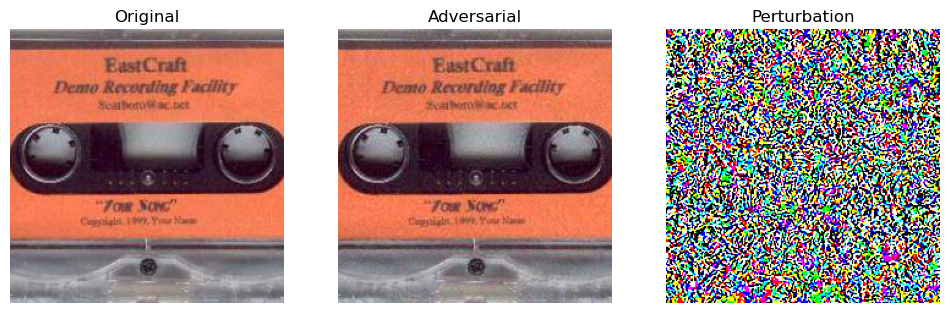

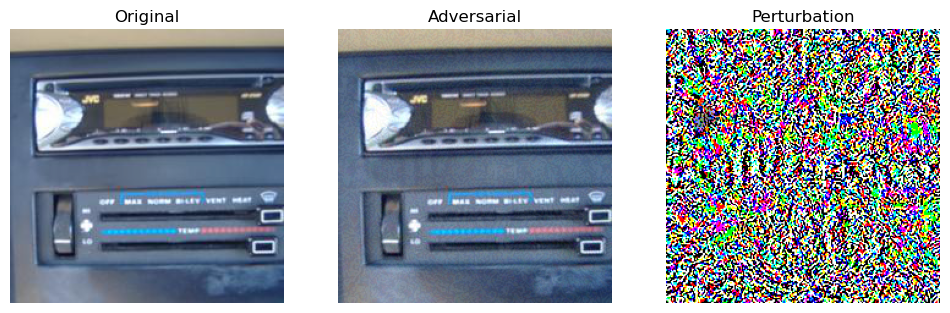

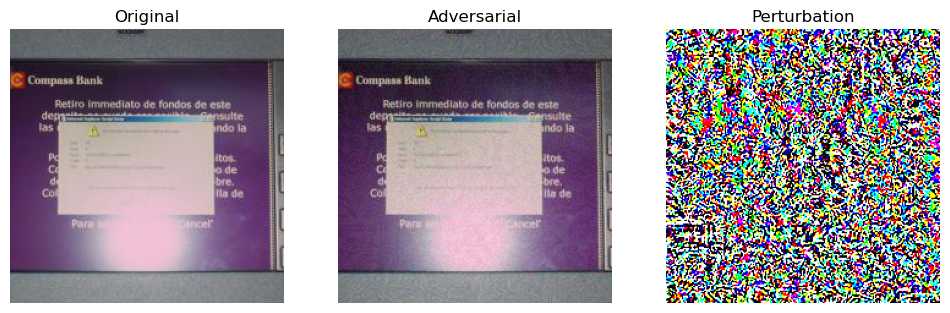

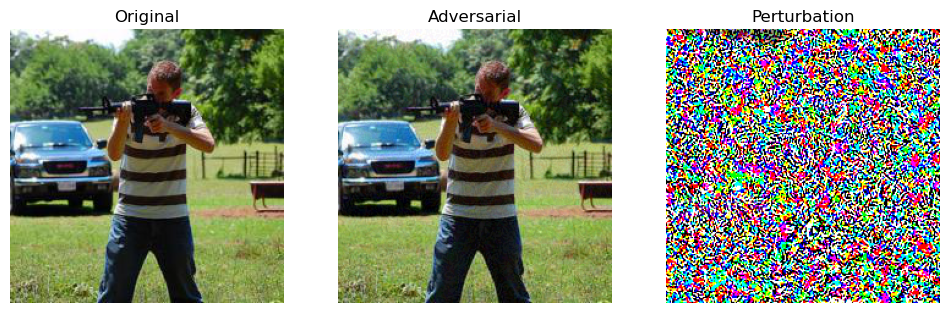

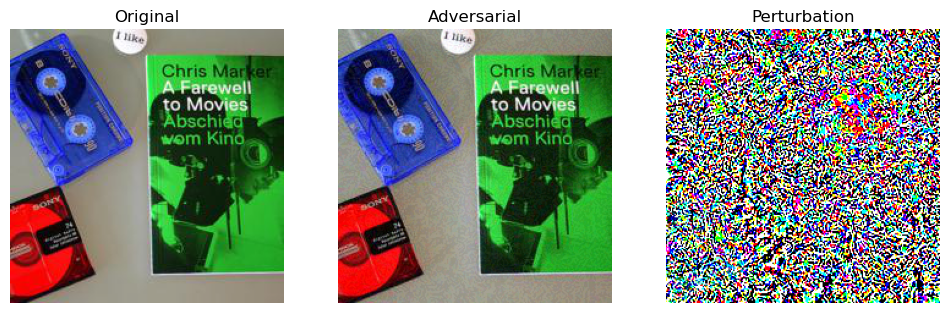

In [27]:
# 4) Visualising 5 random examples 

n = orig_imgs.size(0)
idxs = random.sample(range(n), k=5)

for i, idx in enumerate(idxs):
    o = inv_norm(orig_imgs[idx].cpu()).permute(1,2,0).clamp(0,1).numpy()
    a = inv_norm(adv_imgs[idx].cpu()).permute(1,2,0).clamp(0,1).numpy()
    d = (a - o)  # perturbation

    fig, axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(o); axes[0].set_title("Original")
    axes[1].imshow(a); axes[1].set_title("Adversarial")
    # normalize diff for display
    diff_norm = (d - d.min())/(d.max() - d.min())
    axes[2].imshow(diff_norm); axes[2].set_title("Perturbation")
    for ax in axes: ax.axis("off")
    plt.show()

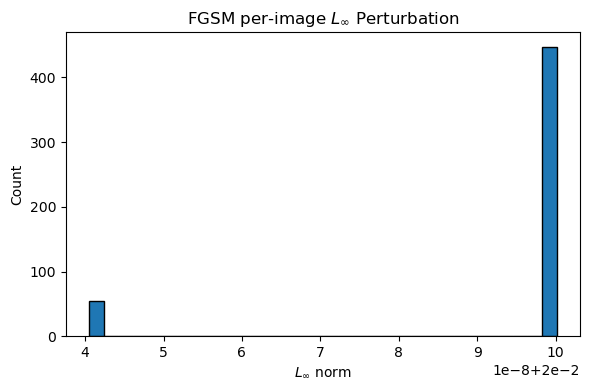

In [46]:
# ─── FGSM perturbation histogram ────────────────────────────────────────────────
import matplotlib.pyplot as plt

mean_t = torch.tensor(mean, device=device).view(1,3,1,1)
std_t  = torch.tensor(std,  device=device).view(1,3,1,1)
orig_px = orig_imgs * std_t + mean_t
adv_px  = adv_imgs  * std_t + mean_t

# per-image L∞ norms
fgsm_linf = (adv_px - orig_px).abs().view(orig_px.size(0), -1).max(dim=1)[0].cpu().numpy()

plt.figure(figsize=(6,4))
plt.hist(fgsm_linf, bins=30, edgecolor='k')
plt.title("FGSM per-image $L_\\infty$ Perturbation")
plt.xlabel("$L_\\infty$ norm")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Task 3: Improved attacks

Now that you have two accuracy metrics (one for the original test set, and one for **Adversarial Test Set 1**), propose ways to improve your attack and degrade performance even further.

Remember: you can do **whatever you like to the original test images**, as long as the **ε constraint is met** and you achieve **worse performance than FGSM**.

Options include:
- Multiple gradient steps (e.g., iterative FGSM / PGD)
- Targeted attacks
- Use of other optimizers (e.g., momentum-based)
- Any technique that remains within the allowed ε limit

---

You should now have a new set of 500 images. Verify that:
- The new images are **visually similar** to the original test set
- The **L∞ distance** between new and original is **no greater than ε = 0.02**

Save this dataset (call it **“Adversarial Test Set 2”**).

- Visualize performance for **3–5 example images**
- Evaluate **ResNet-34 performance** and report new **top-1** and **top-5 accuracy** scores

You should strive to achieve an **accuracy drop of at least 70%** relative to your baseline numbers from Task 1.

In [29]:
# 1) PGD parameters
epsilon = 0.02                
steps   = 10                  
alpha   = epsilon / 4         

# normalized
eps_norm = torch.tensor([epsilon/s for s in std], device=device)\
                .view(1,3,1,1)
min_norm = torch.tensor([(0-m)/s for m,s in zip(mean,std)], device=device)\
                .view(1,3,1,1)
max_norm = torch.tensor([(1-m)/s for m,s in zip(mean,std)], device=device)\
                .view(1,3,1,1)

In [30]:
# 2) PGD attack loop 
orig_batches, adv_batches, lbl_batches = [], [], []

model.eval()
for x, y in loader:
    x, y = x.to(device), y.to(device)
    ori = x.clone().detach()
    
    # initialize with a small random noise 
    adv = ori + (torch.rand_like(ori) * 2 - 1) * eps_norm
    adv = torch.clamp(adv, min_norm, max_norm).detach()
    
    for _ in range(steps):
        adv.requires_grad_()
        out  = model(adv)
        loss = F.cross_entropy(out, y)
        model.zero_grad()
        loss.backward()
        
        # gradient step
        adv = adv + alpha * adv.grad.sign()
        
        # project back into ε-ball & valid range
        delta = torch.clamp(adv - ori, -eps_norm, eps_norm)
        adv   = torch.clamp(ori + delta, min_norm, max_norm).detach()
    
    orig_batches.append(ori)
    adv_batches.append(adv)
    lbl_batches.append(y)

orig_pgd = torch.cat(orig_batches)
adv_pgd  = torch.cat(adv_batches)
pgd_lbls = torch.cat(lbl_batches)

In [31]:
# 3) Evaluate PGD set 
pgd_ds     = TensorDataset(adv_pgd, pgd_lbls)
pgd_loader = DataLoader(pgd_ds, batch_size=64, shuffle=False)
top1_pgd, top5_pgd = evaluate(pgd_loader)
print(f"PGD-{steps} (ε={epsilon}) → Top-1: {top1_pgd:.2f}%   Top-5: {top5_pgd:.2f}%")

PGD-10 (ε=0.02) → Top-1: 0.00%   Top-5: 4.19%


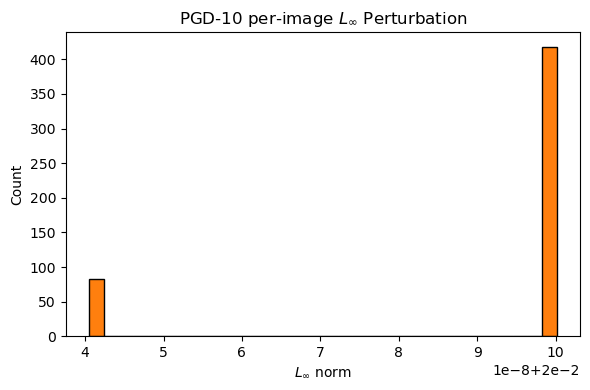

In [45]:
# ─── PGD perturbation histogram ────────────────────────────────────────────────
import matplotlib.pyplot as plt

orig_px_p = orig_pgd * std_t + mean_t
adv_px_p  = adv_pgd  * std_t + mean_t

pgd_linf = (adv_px_p - orig_px_p).abs().view(orig_px_p.size(0), -1).max(dim=1)[0].cpu().numpy()

plt.figure(figsize=(6,4))
plt.hist(pgd_linf, bins=30, edgecolor='k', color='C1')
plt.title("PGD-10 per-image $L_\\infty$ Perturbation")
plt.xlabel("$L_\\infty$ norm")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

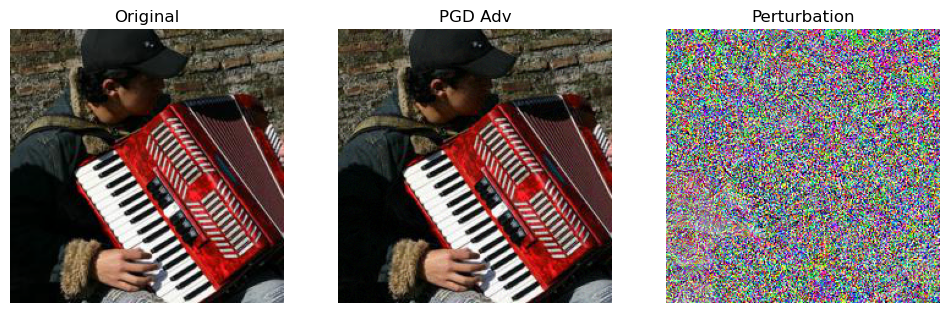

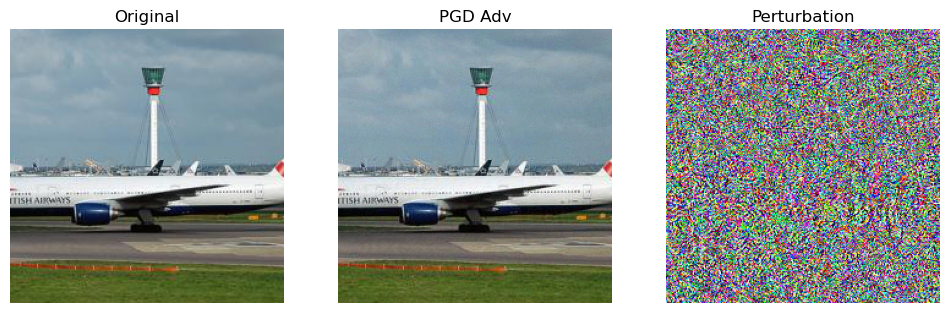

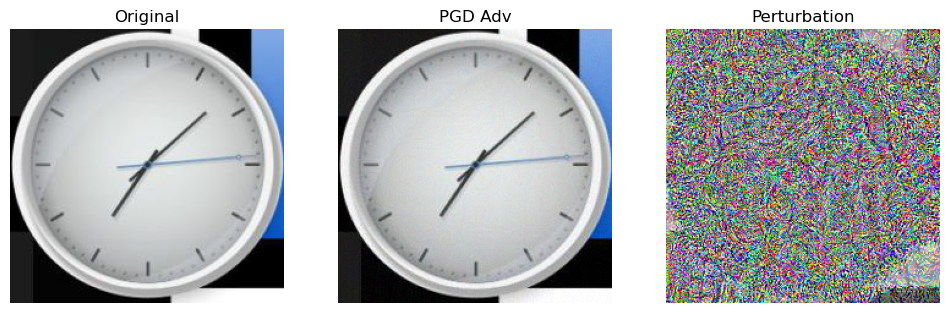

In [33]:
# 4) Visualize 3 examples 

for idx in [0, 17, 42]:    
    o = inv_norm(orig_pgd[idx].cpu()).permute(1,2,0).clamp(0,1).numpy()
    a = inv_norm(adv_pgd[idx].cpu()).permute(1,2,0).clamp(0,1).numpy()
    d = (a - o)
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(o); ax[0].set_title("Original")
    ax[1].imshow(a); ax[1].set_title("PGD Adv")
    dn = (d - d.min())/(d.max()-d.min())
    ax[2].imshow(dn); ax[2].set_title("Perturbation")
    for a in ax: a.axis("off")
    plt.show()

## Task 4: Patch attacks

Pick your **best performing attack method so far**, but now implement it such that you **aren’t perturbing the whole test image**, but **only a small random patch of size 32×32**.

This is going to be more challenging, since as the attacker you have fewer knobs to twiddle around. Therefore, you are free to increase **ε to a much larger amount** (e.g., **0.3** or even **0.5**) to make your attack work.

> **Hint**: A **targeted attack** might be helpful in this context.

---

You should now have a new set of **500 images**.  
- Save this dataset (call it **“Adversarial Test Set 3”**)
- Visualize performance for **3–5 example images**
- Evaluate **ResNet-34 performance** and report **new top-1 and top-5 accuracy scores**

In [34]:
patch_size   = 32
epsilon_patch= 0.3                   
alpha_patch  = epsilon_patch / 4     
steps_patch  = 10                    

# normalized budgets & clamps
eps_norm_p   = torch.tensor([epsilon_patch/s for s in std],
                            device=device).view(1,3,1,1)
min_norm     = torch.tensor([(0-m)/s for m,s in zip(mean,std)],
                            device=device).view(1,3,1,1)
max_norm     = torch.tensor([(1-m)/s for m,s in zip(mean,std)],
                            device=device).view(1,3,1,1)

In [35]:
def make_masks(batch_shape, patch_size):
    # batch_shape = (B, C, H, W)
    B, C, H, W = batch_shape
    masks = torch.zeros(batch_shape, device=device)
    for i in range(B):
        top  = random.randrange(0, H - patch_size + 1)
        left = random.randrange(0, W - patch_size + 1)
        masks[i, :, top:top+patch_size, left:left+patch_size] = 1.0
    return masks

In [36]:
orig_p, adv_p, lbl_p = [], [], []
model.eval()

for x, y in loader:
    x, y = x.to(device), y.to(device)
    ori  = x.clone().detach()
    
    # initializing adversarial = original (no noise)
    adv = ori.clone().detach()
    
    # creating one random patch‐mask per image
    mask = make_masks(ori.shape, patch_size)
    
    for _ in range(steps_patch):
        adv.requires_grad_()
        out  = model(adv)
        loss = F.cross_entropy(out, y)
        model.zero_grad()
        loss.backward()
        
        # stepping only inside the mask
        adv = adv + alpha_patch * adv.grad.sign() * mask
        
        # project: keeping changes ≤ ε in mask, zero outside
        delta = adv - ori
        delta = torch.clamp(delta, -eps_norm_p, eps_norm_p) * mask
        adv   = torch.clamp(ori + delta, min_norm, max_norm).detach()
    
    orig_p.append(ori)
    adv_p.append(adv)
    lbl_p.append(y)

orig_patch = torch.cat(orig_p)
adv_patch  = torch.cat(adv_p)
lbl_patch  = torch.cat(lbl_p)

In [37]:
patch_ds     = TensorDataset(adv_patch, lbl_patch)
patch_loader = DataLoader(patch_ds, batch_size=64, shuffle=False)

top1_patch, top5_patch = evaluate(patch_loader)
print(f"Patch-32×32 PGD (ε={epsilon_patch}) → Top-1: {top1_patch:.2f}%   Top-5: {top5_patch:.2f}%")

Patch-32×32 PGD (ε=0.3) → Top-1: 41.12%   Top-5: 76.85%


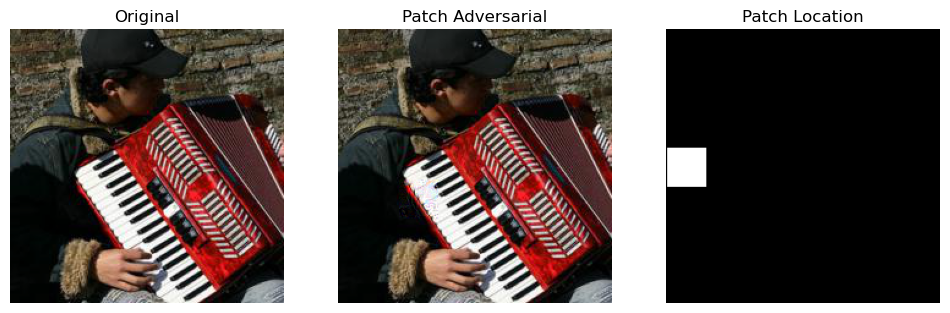

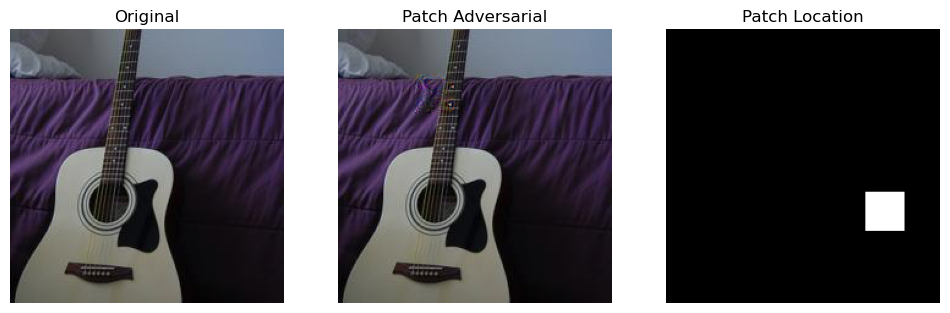

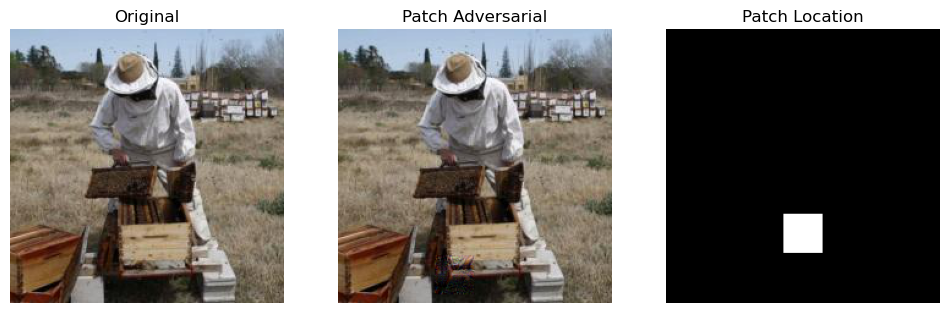

In [38]:
for idx in [0, 10, 50]:
    o = inv_norm(orig_patch[idx].cpu()).permute(1,2,0).clamp(0,1).numpy()
    a = inv_norm(adv_patch[idx].cpu()).permute(1,2,0).clamp(0,1).numpy()
    # recomputing mask for this image's shape
    shape = orig_patch[idx:idx+1].shape
    mask = make_masks(shape, patch_size)[0]          # (3,H,W)
    mask2d = mask.max(dim=0)[0].cpu().numpy()        # collapse channels
    
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(o);       ax[0].set_title("Original")
    ax[1].imshow(a);       ax[1].set_title("Patch Adversarial")
    ax[2].imshow(mask2d, cmap="gray")
    ax[2].set_title("Patch Location")
    for a in ax: a.axis("off")
    plt.show()

In [39]:
out_root = Path("AdversarialTestSet3")
for i, (orig_path, _) in enumerate(ds.samples):
    rel     = Path(orig_path).relative_to(root)
    save_p  = out_root/rel
    save_p.parent.mkdir(parents=True, exist_ok=True)
    img     = inv_norm(adv_patch[i].cpu()).clamp(0,1)
    save_image(img, save_p)
print("Saved 501 patched images to AdversarialTestSet3/")

Saved 501 patched images to AdversarialTestSet3/


## Task 5: Transferring attacks

You now have **three perturbed versions** of the original test set.  
Evaluate classification accuracy of these datasets using **any pre-trained network other than ResNet-34**.

You can choose any model you like; for example:

```python
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')

A full list of ImageNet-1K models are available at this [Link](https://pytorch.org/vision/main/models.html)
.

List out top-1 and top-5 accuracies for all 4 datasets: original + the 3 adversarial test
sets you constructed. Comment on your findings, any trends observed, lessons learned
from this task, and potential ways to mitigate transferability.

In [40]:
# 1) Loading the new model
d121 = torchvision.models.densenet121(weights="IMAGENET1K_V1")\
              .to(device).eval()

In [41]:
# 2) helper to evaluate any model on any loader
def eval_model(model, loader):
    top1 = top5 = 0.0
    n = len(loader.dataset)
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            top1 += topk_correct(out, y, 1)
            top5 += topk_correct(out, y, 5)
    return top1/n*100, top5/n*100

In [42]:
# 3) building loaders
fgsm_loader   = DataLoader(TensorDataset(adv_imgs, adv_lbls), batch_size=64, shuffle=False)
pgd_loader    = DataLoader(TensorDataset(adv_pgd, pgd_lbls), batch_size=64, shuffle=False)
patch_loader  = DataLoader(TensorDataset(adv_patch, lbl_patch), batch_size=64, shuffle=False)

In [43]:
# 4) evaluating both models on all 4 datasets
print("ResNet-34 results:")
print("  Original:", evaluate(loader))
print("  FGSM:    ", evaluate(fgsm_loader))
print("  PGD:     ", evaluate(pgd_loader))
print("  Patch:   ", evaluate(patch_loader))

print("\nDenseNet-121 results:")
print("  Original:", eval_model(d121, loader))
print("  FGSM:    ", eval_model(d121, fgsm_loader))
print("  PGD:     ", eval_model(d121, pgd_loader))
print("  Patch:   ", eval_model(d121, patch_loader))

ResNet-34 results:
  Original: (75.84830339321357, 94.01197604790418)
  FGSM:     (3.1936127744510974, 20.758483033932134)
  PGD:      (0.0, 4.191616766467066)
  Patch:    (41.11776447105788, 76.84630738522954)

DenseNet-121 results:
  Original: (75.249500998004, 93.6127744510978)
  FGSM:     (44.31137724550898, 76.64670658682635)
  PGD:      (58.48303393213573, 88.02395209580838)
  Patch:    (70.65868263473054, 92.61477045908184)


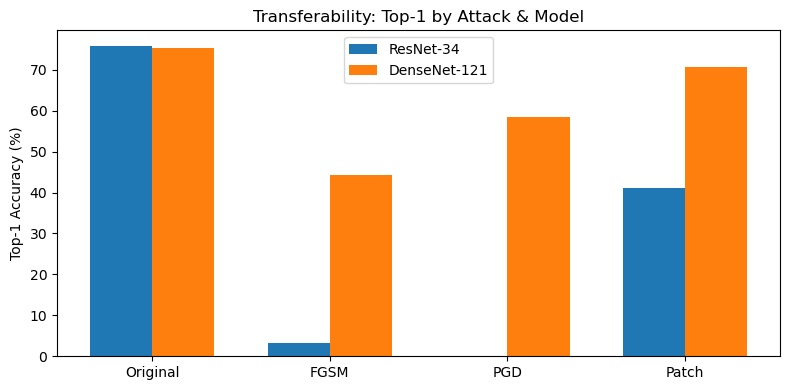

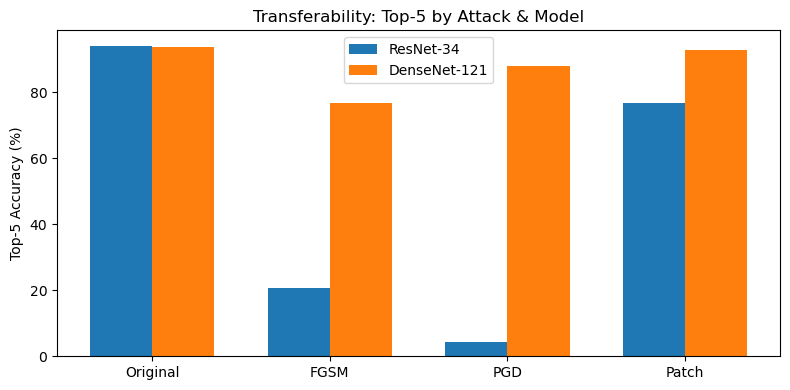

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Attack labels and accuracy results
attacks = ["Original", "FGSM", "PGD", "Patch"]

# Top-1 accuracies
resnet_top1    = [75.84830339321357, 3.1936127744510974, 0.0, 41.11776447105788]
densenet_top1  = [75.249500998004, 44.31137724550898, 58.48303393213573, 70.65868263473054]

# Top-5 accuracies
resnet_top5    = [94.01197604790418, 20.758483033932134, 4.191616766467066, 76.84630738522954]
densenet_top5  = [93.6127744510978, 76.64670658682635, 88.02395209580838, 92.61477045908184]

x = np.arange(len(attacks))
width = 0.35

# Plot Top-1 transferability
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width/2, resnet_top1, width, label="ResNet-34")
ax.bar(x + width/2, densenet_top1, width, label="DenseNet-121")
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.set_ylabel("Top-1 Accuracy (%)")
ax.set_title("Transferability: Top-1 by Attack & Model")
ax.legend()
plt.tight_layout()
plt.show()

# Plot Top-5 transferability
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width/2, resnet_top5, width, label="ResNet-34")
ax.bar(x + width/2, densenet_top5, width, label="DenseNet-121")
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.set_ylabel("Top-5 Accuracy (%)")
ax.set_title("Transferability: Top-5 by Attack & Model")
ax.legend()
plt.tight_layout()
plt.show()

## Key Observations

### ResNet-34 is extremely brittle to unstructured L∞ attacks:

- **FGSM (single-step)** slashes Top-1 from **75.8% → 3.2%**
- **Multi-step PGD** drives Top-1 to **0%**
- Even the **patch-only attack** (with ε = 0.3) cuts accuracy nearly in half

---

### DenseNet-121 shows greater robustness and different transfer patterns:

- **FGSM attack transfers moderately** → Top-1 drops to **44%**
- **PGD attacks transfer even more** → Top-1 only recovers to **59%**  
  *(a 16-point gap vs. FGSM)*
- **Patch-only perturbations transfer the least** → Accuracy remains **above 70%**

---

### Transferability Trend:

> Stronger, multi-step attacks (e.g., PGD) crafted on one model can generalize better to another model than simpler single-step attacks.  
> This highlights that once you find a “worst-case” direction in pixel space, it often affects **multiple architectures**.

---

## Lessons Learned & Mitigation Ideas

- **Adversarial training** on a diverse set of attacks (FGSM + PGD) is one of the most reliable defenses
- **Input preprocessing** (e.g., random resizing/cropping, JPEG compression) can break up subtle perturbations
- **Model ensembles** or **randomized smoothing techniques** increase robustness by making attacks harder to transfer
- **Patch defenses** (e.g., patch-wise denoising or attention masking) help mitigate **localized attacks**